In [9]:
from IPython.display import HTML

HTML('''
<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.input').show();
    } else {
        $('div.input').hide();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>''')

# Classifying Sunset Images by Fine Tuning CaffeNet (A minor variant of AlexNet)

About finetuning CaffeNet:

- My general strategy on finetuning is as follows:
    
    * For layers that inherit pretrained weights from CaffeNet, I set their lr_mult to be zero; this will make sure these layers inherit the weights and not change the weights during the fine tuning (training) process. This will also significantly reduces the training time since we don't update these weights and consequently no backward computation will be needed for these layers. 
    
    * For layers that need to learn new weights and finetune particularly for the sunset dataset, I set their lr_mult to be nonzero; also, I need to change the layer names so that when the CaffeNet imports weights, it will not put weights to these layers. These layers will learn new weights from scratch particularly for the new sunset dataset. 
    
    * Note that I could've set all layer's lr_mult to be nonzero and let all layers import weights; this means I fine tune all layers on top of pretrained weights. This may give a more suited model for sunset dataset, but it would probably consume longer computing time. Further more, limiting the finetuning layers to 2 or 3 layers already gave pretty good convergence rate and performance as I will show in the following sections. 

- To avoid shape mismatch error, I needed to be careful about InnerProduct layers in CaffeNet. In particular, n.fc6, n.fc7, n.fc8 are the last three InnerProduct layers in CaffeNet. To fine tune CaffeNet to classify Sunset images, I need to re-learn weights for these InnerProduct layers, and not just the very last on, n.fc8. This is because n.fc6, n.fc7 both depends on the input dimensions of new data, the sunset images. To make sure the fine tuned CaffeNet works without shape mismatch error, I have to tune weights on all three InnerProduct layers. 

- To do this, when I define the CaffeNet structure, I renamed both n.fc6 and n.fc8 to n.fc6_sunset and n.fc8_sunset; this tells CaffeNet to not inherit weights from the pretrained model. For some reason, I didn't need to rename n.fc7 and it didn't bring error. I am guessing this is because n.fc7 is taking output from n.fc6 and thus doesn't directly correspond to the new input data dimensions. The reason we must rename n.fc6 is that n.fc6 is sensitive to new data shapes; and the reason we must rename n.fc8 is because it is the last fully connected layer before loss, accuracy, and prob computation and we need to fine tune it according to the new sunset dataset. I set all last three InnerProduct layers to learn new weights (by setting lr_mult!=0) and let other layers inherit pretrained weights (n.fc7 will start with pretrained weights and will learn on the training process, whereas n.fc6 and n.fc8 learns weights totally from scratch).  


In [10]:
%matplotlib inline
import sunset_helper
import sunset_helper_aug
import log_parser
# import log_parser
caffe_root = '/usr/local/caffe/'
code_root='/Users/tianchuliang/Documents/Projects/my_sunset_net/my_sunset_net/code'
data_root='/Users/tianchuliang/Documents/Projects/my_sunset_net/my_sunset_net/data'
nets_root='/Users/tianchuliang/Documents/Projects/my_sunset_net/my_sunset_net/nets'
sunset_lmdb=data_root+"/Sunset"

In [11]:
train_net_path = sunset_helper.sunset_net(sunset_lmdb,50,train=True)
test_net_path = sunset_helper.sunset_net(sunset_lmdb,50,train=False)
sunset_solver_filename = sunset_helper.solver(train_net_path, test_net_path= test_net_path, 
                                             displayFreq=5,test_interval=5,stepsize=150)

# Train on original sunset images

The first model was trained on the original sunset images for 300 iterations, with batch size = 50; this is equivalent to about 50 epochs. 

In [12]:
print "Solver: ", sunset_solver_filename
print "Train: ", train_net_path
print "Test: ", test_net_path

Solver:  /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_solver_cmdline.prototxt
Train:  /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_train_cmdline.prototxt
Test:  /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_test_cmdline.prototxt


## Solver prototxt file: 

In [13]:
!cat /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_solver_cmdline.prototxt

train_net: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_train_cmdline.prototxt"
test_net: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_test_cmdline.prototxt"
test_iter: 50
test_interval: 5
base_lr: 0.001
display: 5
max_iter: 100000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 150
snapshot: 100
snapshot_prefix: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_cmdline"
solver_mode: CPU
iter_size: 1
type: "SGD"


## Train prototxt file: 

In [14]:
!cat /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_train_cmdline.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    mirror: false
    crop_size: 256
    mean_file: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/data/Sunset/Train/sunset_train_mean.binaryproto"
  }
  data_param {
    source: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/data/Sunset/Train/sunset_train_lmdb"
    batch_size: 50
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 0
  }
  param {
    lr_mult: 0
  }
  convolution_param {
    num_output: 96
    pad: 0
    kernel_size: 11
    group: 1
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    s

## Test prototxt file:

In [15]:
!cat /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_test_cmdline.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    mirror: false
    crop_size: 256
    mean_file: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/data/Sunset/Train/sunset_train_mean.binaryproto"
  }
  data_param {
    source: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/data/Sunset/Test/sunset_test_lmdb"
    batch_size: 50
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 0
  }
  param {
    lr_mult: 0
  }
  convolution_param {
    num_output: 96
    pad: 0
    kernel_size: 11
    group: 1
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    str

Execute the solver by typing the following command in the terminal: (you can find the corresponding bash script that executes the following command in ~/hw4/code/bash/train_my_sunset_net.sh) 

>>
/usr/local/caffe/build/tools/caffe train -solver /Users/tianchuliang/documents/gt_acad/7616Spring16/HWSoln/hw4/nets/my_sunset_net/sunset_solver_cmdline.prototxt -weights /Users/tianchuliang/documents/gt_acad/7616Spring16/HWSoln/hw4/nets/caffenet/caffenet.caffemodel 2>&1 | tee  /Users/tianchuliang/documents/gt_acad/7616Spring16/HWSoln/hw4/nets/my_sunset_net/my_sunset_net_cmdline.log

Notice, the above command also explicity asks Caffe to produce a log file: my_sunset_net_cmdline.log. From this log file we can extract information on training loss, accuracy and similarly for testing. 

After training, we can use Caffe's builtin parser to parse the log file into training and testing logs; I have written a small bash script ~/hw4/code/split_log_file.sh that executes the Caffe parser command.

In [17]:
import os
os.chdir(code_root+'/bash')
os.system('chmod +x split_log_file.sh')
os.system('./split_log_file.sh')

0

Then, with train.log and test.log, we can start plotting:

In [18]:
train_log_file = nets_root+'/my_sunset_net/my_sunset_net_cmdline.log.train'
test_log_file = nets_root+'/my_sunset_net/my_sunset_net_cmdline.log.test'
train_iters,train_loss,train_acc=log_parser.parse_train(train_log_file)
test_iters,test_loss,test_acc=log_parser.parse_test(test_log_file)

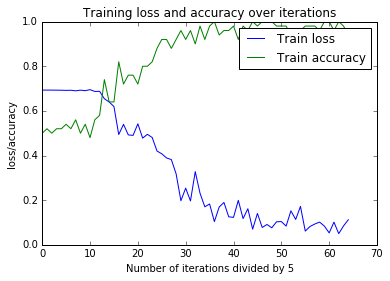

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('Training loss and accuracy over iterations')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('loss/accuracy')
plt.plot(train_loss)
plt.plot(train_acc)
plt.legend(['Train loss','Train accuracy'])
plt.show()

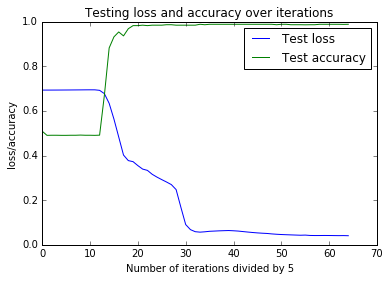

In [22]:
plt.title('Testing loss and accuracy over iterations')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('loss/accuracy')
plt.plot(test_loss)
plt.plot(test_acc)
plt.legend(['Test loss','Test accuracy'])
plt.show()

Also, we can use the trained my_sunset_net model (300 iterations, approximately 30 epochs) to make predictions on the test lmdb and plot corresponding confusion matrix. 

# Demonstrate the network works using deploy.prototxt

Below, I will deploy my trained my_sunset_net (trained for 30 epochs) using the deploy.prototxt, and test 5 random sunset images and 5 random nonsunset images. 

In [2]:
import caffe
deployed_net = caffe.Net(nets_root+'/my_sunset_net/deploy.prototxt',nets_root+'/my_sunset_net/my_sunset_net_cmdline_iter_300.caffemodel'
                        ,caffe.TEST)

In [3]:
# Since we are using the deployed my_sunset_net, we need to load images directly 
# using cv2 the data folder:
import cv2 
import os 
import numpy as np
pos_dat = data_root+'/Sunset/Test/sunset'
neg_dat = data_root+'/Sunset/Test/nonsunset'
false_pos = []
false_neg = []
labels = []
pos_files = np.array(os.listdir(pos_dat))[np.random.choice(240,5,replace=False)]
neg_files = np.array(os.listdir(neg_dat))[np.random.choice(240,5,replace=False)]

In [4]:
print "Test on these sunset images: ", pos_files

Test on these sunset images:  ['sunset_test_00146.jpg' 'sunset_test_00120.jpg' 'sunset_test_00056.jpg'
 'sunset_test_00145.jpg' 'sunset_test_00113.jpg']


In [5]:
print "Test on these nonsunset images", neg_files

Test on these nonsunset images ['nonsunset_test_00207.jpg' 'nonsunset_test_00060.jpg'
 'nonsunset_test_00216.jpg' 'nonsunset_test_00098.jpg'
 'nonsunset_test_00035.jpg']


 ***Testing sunset images:***


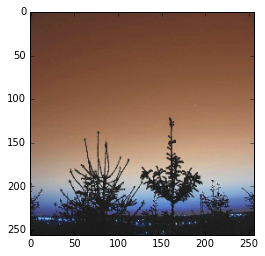

Possible labels [1]
Classification result:  sunset
***Testing sunset images:***


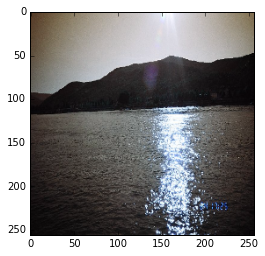

Possible labels [1]
Classification result:  sunset
***Testing sunset images:***


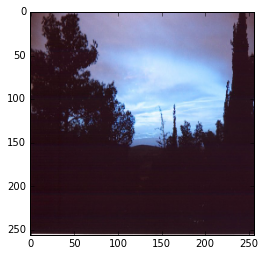

Possible labels [1]
Classification result:  sunset
***Testing sunset images:***


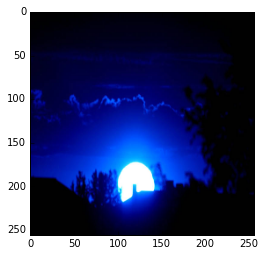

Possible labels [1]
Classification result:  sunset
***Testing sunset images:***


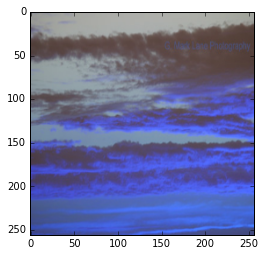

Possible labels [1]
Classification result:  sunset


In [8]:
import matplotlib.pyplot as plt
for pos_file in pos_files:
    print '***Testing sunset images:***'
    if pos_file == '.DS_Store':
        continue
    else:
        labels.append(1)
        img = cv2.imread(pos_dat+'/'+pos_file)
        img = cv2.resize(img,(256,256))
        plt.imshow(img)
        plt.show()
        in_ = np.array(img,dtype=np.float32)
        in_ = in_[:,:,::-1]
        in_ -= np.array((104.00698793,116.66876762,122.67891434))
        in_ = in_.transpose((2,0,1))
        deployed_net.blobs['data'].reshape(1, *in_.shape)
        deployed_net.blobs['data'].data[...] = in_
        deployed_net.forward()
        out_probs = deployed_net.blobs['prob'].data[...]
        out = out_probs[:,:].argmax(axis=1)
        print 'Possible labels', out
        dic = {1:'sunset',0:'nonsunset'}
        print 'Classification result: ',dic[int(np.unique(out))]

***Testing nonsunset images:***


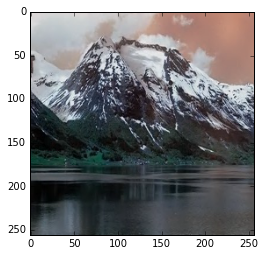

Possible labels [0]
Classification result:  nonsunset
***Testing nonsunset images:***


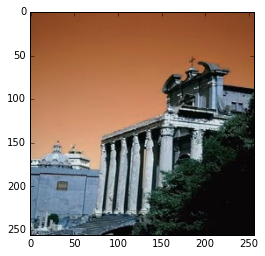

Possible labels [0]
Classification result:  nonsunset
***Testing nonsunset images:***


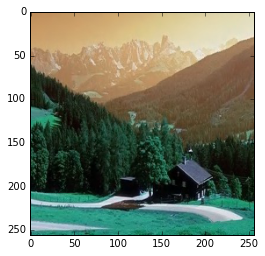

Possible labels [0]
Classification result:  nonsunset
***Testing nonsunset images:***


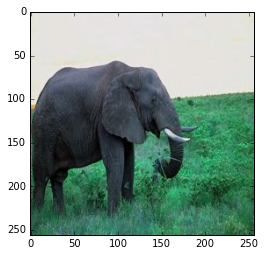

Possible labels [0]
Classification result:  nonsunset
***Testing nonsunset images:***


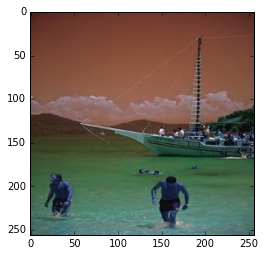

Possible labels [0]
Classification result:  nonsunset


In [9]:
import matplotlib.pyplot as plt
for neg_file in neg_files:
    print '***Testing nonsunset images:***'
    if neg_file == '.DS_Store':
        continue
    else:
        labels.append(1)
        img = cv2.imread(neg_dat+'/'+neg_file)
        img = cv2.resize(img,(256,256))
        plt.imshow(img)
        plt.show()
        in_ = np.array(img,dtype=np.float32)
        in_ = in_[:,:,::-1]
        in_ -= np.array((104.00698793,116.66876762,122.67891434))
        in_ = in_.transpose((2,0,1))
        deployed_net.blobs['data'].reshape(1, *in_.shape)
        deployed_net.blobs['data'].data[...] = in_
        deployed_net.forward()
        out_probs = deployed_net.blobs['prob'].data[...]
        out = out_probs[:,:].argmax(axis=1)
        print 'Possible labels', out
        dic = {1:'sunset',0:'nonsunset'}
        print 'Classification result: ',dic[int(np.unique(out))]
        

# Confusion Matrix

** To make computation, plotting, and false positive/negative extraction easier, I directly used the test net .prototxt file instead of using the deploy.prototxt. **

In [2]:
import caffe
from sklearn.metrics import confusion_matrix
test_net = caffe.Net(nets_root+'/my_sunset_net/my_sunset_net_test_cmdline.prototxt',
                    nets_root+'/my_sunset_net/my_sunset_net_cmdline_iter_300.caffemodel'
                    ,caffe.TEST)

In [3]:
import numpy as np
import cv2
import os
y_true=np.zeros(1)
y_test=np.zeros(1)
for iter in range(20):
    test_net.forward()
    y_true = np.hstack([y_true,test_net.blobs['label'].data])
    y_test = np.hstack([y_test,test_net.blobs['probs'].data.argmax(1)])
y_true=y_true[1:]
y_test=y_test[1:]

In [4]:
y_true=np.array(y_true).flatten()
y_test=np.array(y_test).flatten()

In [5]:
conf_mat = confusion_matrix(y_true, y_test)

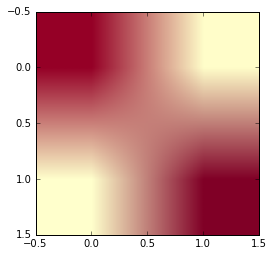

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
imgplot = plt.imshow(conf_mat,cmap='YlOrRd')

In [7]:
print conf_mat

[[483   8]
 [  4 505]]


# False positives and False negatives

In [138]:
f_pos = []
f_neg = []
for i in range (10):
    test_net.forward()
    diff = test_net.blobs['label'].data - test_net.blobs['probs'].data.argmax(1)
    f_pos_inds = np.where(diff == -1)
    f_neg_inds = np.where(diff == 1)
    
    try:
        if ((f_pos_inds[0]>=0)[0]):
            f_pos.append(test_net.blobs['data'].data[f_pos_inds])
        print 'Adding false positives'
    except IndexError:
        pass
    
    try:
        if ((f_neg_inds[0]>=0)[0]):
            f_neg.append(test_net.blobs['data'].data[f_neg_inds])
        print 'Adding false negatives'
    except IndexError:
        pass


Adding false positives
Adding false negatives
Adding false positives
Adding false positives
Adding false negatives


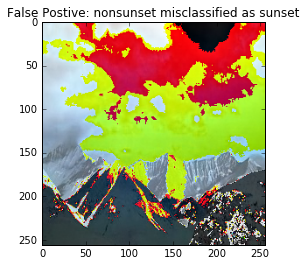

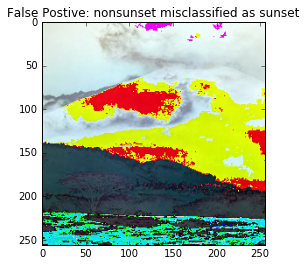

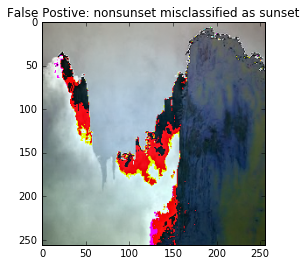

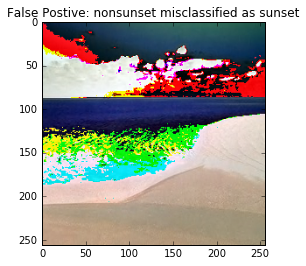

In [141]:
for j in range (len(f_pos)):
    for k in range (f_pos[j].shape[0]):
        im = np.zeros((256,256,3))
        im[:,:,0]=f_pos[j][k][0]
        im[:,:,1]=f_pos[j][k][1]
        im[:,:,2]=f_pos[j][k][2]
        plt.title("False Postive: nonsunset misclassified as sunset")
        plt.imshow(im.astype('uint16'),cmap='jet')
        plt.show()

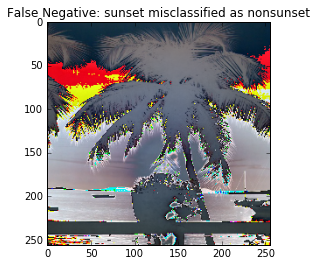

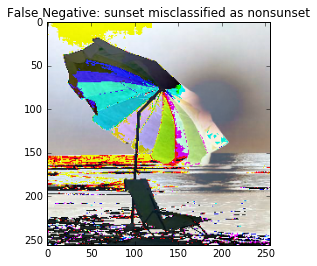

In [142]:
for l in range (len(f_neg)):
    for m in range (f_neg[l].shape[0]):
        im = np.zeros((256,256,3))
        im[:,:,0]=f_neg[l][m][0]
        im[:,:,1]=f_neg[l][m][1]
        im[:,:,2]=f_neg[l][m][2]
        plt.title("False Negative: sunset misclassified as nonsunset")
        plt.imshow(im.astype('uint16'))
        plt.show()

** Comment **

As shown above, most false positive images have the sun being blocked. And most false negative images have simple compositions like sunset scenes: horizontal lines, wide color patches, etc. 

# Training the sunset_net with Augmented Images

My strategy toward data recomposition/augmentation is as follows: (All image augmenting is done by the Python script I wrote: ~/hw4/code/python_code/image_aug.py)

In addition to the original training dataset, 499 images, I added 499 times 4 = 1996 images to the training set by:

- Mirroring: I mannually generated mirror images for all 499 original training images and added to the new dataset which I called Train_aug, aug for augmented. 

- Cropping: I mannually cropped out four sides of each image by taking 10% amount of the pixels on the shorter side. This helps focusing on the sun object in each image. Then I added 499 cropped images to the original dataset as well. 

- Color enhancing: I enhanced the color and contrast by a factor of 1.25 for all images. 

- Hue: I also converted RGB original images into HSV images, hoping adding Hue would help. 

In [8]:
train_net_path_aug = sunset_helper_aug.sunset_net(sunset_lmdb,250,train=True)
test_net_path_aug = sunset_helper_aug.sunset_net(sunset_lmdb,50,train=False)
sunset_solver_filename_aug = sunset_helper_aug.solver(train_net_path_aug, test_net_path=test_net_path_aug, 
                                             displayFreq=5,test_interval=5,stepsize=150)

In [9]:
print "Solver: ", sunset_solver_filename_aug
print "Train: ", train_net_path_aug
print "Test: ", test_net_path_aug

Solver:  /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_solver_aug_cmdline.prototxt
Train:  /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_train_aug_cmdline.prototxt
Test:  /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_test_aug_cmdline.prototxt


### Show a few augmented images
I will show below different kinds of augmented images I generated as examples:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
original_path ='/Users/tianchuliang/Documents/GT_Acad/7616Spring16/HWSoln/hw4/data/Sunset/Train_aug/sunset/sunset_train_00068.jpg'
mirror_path = '/Users/tianchuliang/Documents/GT_Acad/7616Spring16/HWSoln/hw4/data/Sunset/Train_aug/sunset/mirrored_68.jpg'
crop_path = '/Users/tianchuliang/Documents/GT_Acad/7616Spring16/HWSoln/hw4/data/Sunset/Train_aug/sunset/center_cropped_68.jpg'
color_path = '/Users/tianchuliang/Documents/GT_Acad/7616Spring16/HWSoln/hw4/data/Sunset/Train_aug/sunset/enhanced_68.jpg'
hue_path ='/Users/tianchuliang/Documents/GT_Acad/7616Spring16/HWSoln/hw4/data/Sunset/Train_aug/sunset/hue_converted_68.jpg'

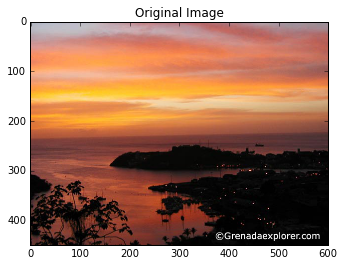

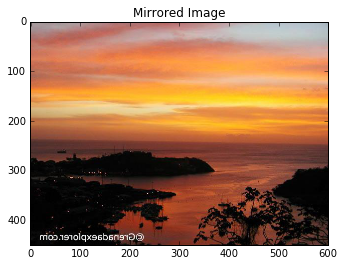

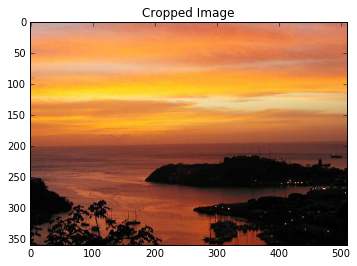

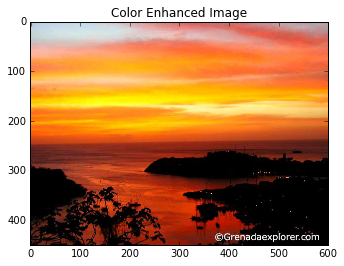

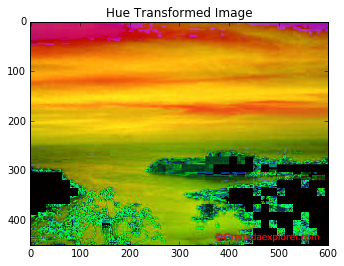

In [8]:
image = mpimg.imread(original_path)
plt.title('Original Image')
plt.imshow(image)
plt.show()
image = mpimg.imread(mirror_path)
plt.title('Mirrored Image')
plt.imshow(image)
plt.show()
image = mpimg.imread(crop_path)
plt.title('Cropped Image')
plt.imshow(image)
plt.show()
image = mpimg.imread(color_path)
plt.title('Color Enhanced Image')
plt.imshow(image)
plt.show()
image = mpimg.imread(hue_path)
plt.title('Hue Transformed Image')
plt.imshow(image)
plt.show()

## Solver prototxt file:

In [10]:
!cat /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_solver_aug_cmdline.prototxt

train_net: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_train_aug_cmdline.prototxt"
test_net: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_test_aug_cmdline.prototxt"
test_iter: 50
test_interval: 5
base_lr: 0.001
display: 5
max_iter: 100000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 150
snapshot: 100
snapshot_prefix: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_aug_cmdline"
solver_mode: CPU
iter_size: 1
type: "SGD"


## Train prototxt file:

In [11]:
!cat /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_train_aug_cmdline.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    mirror: false
    crop_size: 256
    mean_file: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/data/Sunset/Train_aug/sunset_train_aug_mean.binaryproto"
  }
  data_param {
    source: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/data/Sunset/Train_aug/sunset_train_lmdb_aug"
    batch_size: 250
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 0
  }
  param {
    lr_mult: 0
  }
  convolution_param {
    num_output: 96
    pad: 0
    kernel_size: 11
    group: 1
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    ker

## Test prototxt file:

In [12]:
!cat /Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/nets/my_sunset_net/my_sunset_net_test_aug_cmdline.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    mirror: false
    crop_size: 256
    mean_file: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/data/Sunset/Train_aug/sunset_train_aug_mean.binaryproto"
  }
  data_param {
    source: "/Users/tianchuliang/documents/gt_acad/7616spring16/hwsoln/hw4/data/Sunset/Test/sunset_test_lmdb"
    batch_size: 50
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 0
  }
  param {
    lr_mult: 0
  }
  convolution_param {
    num_output: 96
    pad: 0
    kernel_size: 11
    group: 1
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3

In [23]:
import os
os.chdir(code_root+'/bash')
os.system('chmod +x split_log_file_aug.sh')
os.system('./split_log_file_aug.sh')

0

In [24]:
train_log_file = nets_root+'/my_sunset_net/my_sunset_net_aug_cmdline.log.train'
test_log_file = nets_root+'/my_sunset_net/my_sunset_net_aug_cmdline.log.test'
train_iters,train_loss,train_acc=log_parser.parse_train(train_log_file)
test_iters,test_loss,test_acc=log_parser.parse_test(test_log_file)

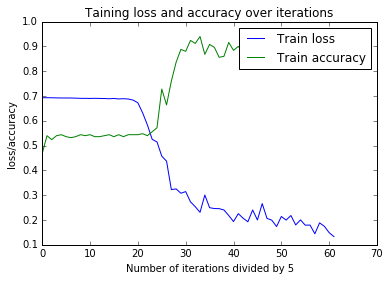

In [25]:
plt.title('Taining loss and accuracy over iterations')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('loss/accuracy')
plt.plot(train_loss)
plt.plot(train_acc)
plt.legend(['Train loss','Train accuracy'])
plt.show()

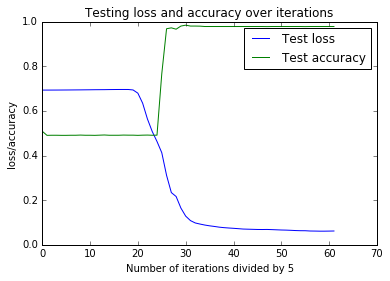

In [26]:
plt.title('Testing loss and accuracy over iterations')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('loss/accuracy')
plt.plot(test_loss)
plt.plot(test_acc)
plt.legend(['Test loss','Test accuracy'])
plt.show()

# Confusion Matrix

In [3]:
import caffe
from sklearn.metrics import confusion_matrix
test_net_aug = caffe.Net(nets_root+'/my_sunset_net/my_sunset_net_test_aug_cmdline.prototxt',
                    nets_root+'/my_sunset_net/my_sunset_net_aug_cmdline_iter_300.caffemodel'
                    ,caffe.TEST)

In [5]:
import numpy as np
y_true=np.zeros(1)
y_test=np.zeros(1)
for iter in range(20):
    test_net_aug.forward()
    y_true = np.hstack([y_true,test_net_aug.blobs['label'].data])
    y_test = np.hstack([y_test,test_net_aug.blobs['probs'].data.argmax(1)])
y_true=y_true[1:]
y_test=y_test[1:]

In [6]:
y_true=np.array(y_true).flatten()
y_test=np.array(y_test).flatten()
conf_mat = confusion_matrix(y_true, y_test)

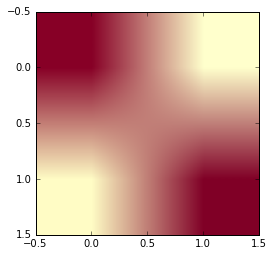

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
imgplot = plt.imshow(conf_mat,cmap='YlOrRd')

In [8]:
print conf_mat

[[485   6]
 [ 16 493]]


# False positives and False negatives

In [9]:
f_pos = []
f_neg = []
for i in range (10):
    test_net_aug.forward()
    diff = test_net_aug.blobs['label'].data - test_net_aug.blobs['probs'].data.argmax(1)
    f_pos_inds = np.where(diff == -1)
    f_neg_inds = np.where(diff == 1)
    
    try:
        if ((f_pos_inds[0]>=0)[0]):
            f_pos.append(test_net_aug.blobs['data'].data[f_pos_inds])
        print 'Adding false positives'
    except IndexError:
        pass
    
    try:
        if ((f_neg_inds[0]>=0)[0]):
            f_neg.append(test_net_aug.blobs['data'].data[f_neg_inds])
        print 'Adding false negatives'
    except IndexError:
        pass


Adding false negatives
Adding false negatives
Adding false negatives
Adding false negatives
Adding false positives
Adding false positives
Adding false negatives
Adding false positives
Adding false negatives
Adding false negatives


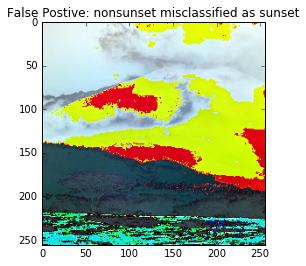

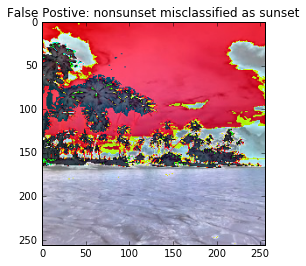

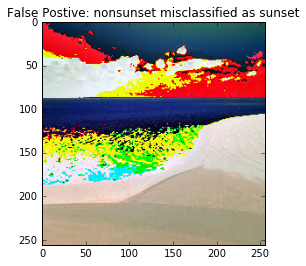

In [10]:
for j in range (len(f_pos)):
    for k in range (f_pos[j].shape[0]):
        im = np.zeros((256,256,3))
        im[:,:,0]=f_pos[j][k][0]
        im[:,:,1]=f_pos[j][k][1]
        im[:,:,2]=f_pos[j][k][2]
        plt.title("False Postive: nonsunset misclassified as sunset")
        plt.imshow(im.astype('uint16'),cmap='jet')
        plt.show()

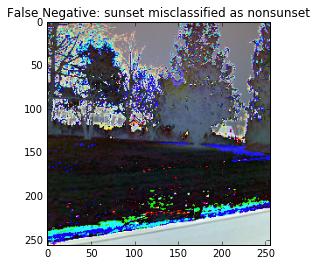

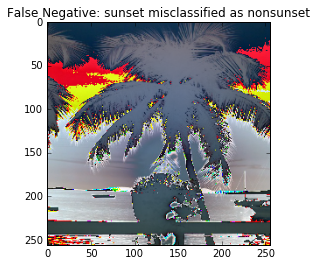

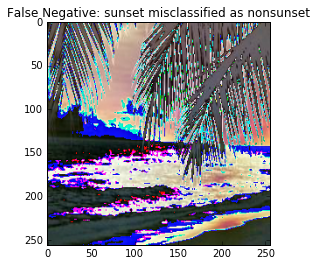

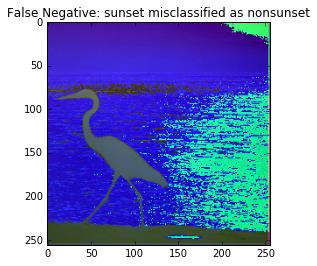

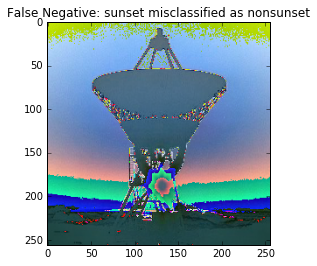

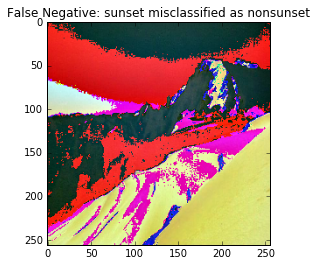

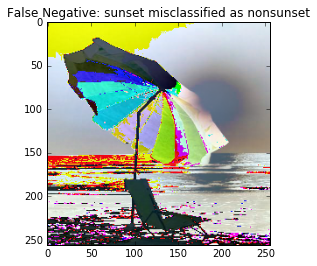

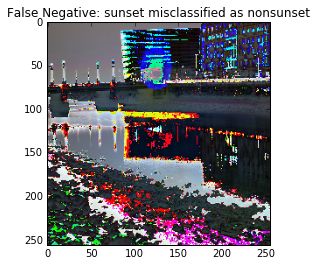

In [11]:
for l in range (len(f_neg)):
    for m in range (f_neg[l].shape[0]):
        im = np.zeros((256,256,3))
        im[:,:,0]=f_neg[l][m][0]
        im[:,:,1]=f_neg[l][m][1]
        im[:,:,2]=f_neg[l][m][2]
        plt.title("False Negative: sunset misclassified as nonsunset")
        plt.imshow(im.astype('uint16'))
        plt.show()

# Analysis:
** Why doesn't augmented training data improve the classifier? **

As shown above, the network trained on the augment data DOES NOT beat the previous one, which is trained on vanilla sunset images. In fact, given more data (original data added with augmented images), the second network actually produced more false positives and false negatives. 

Looking at false positivies and false negatives, we can see that the second model doesn't recognize well the obstructed sunset images, i.e blocked by buildings, trees, unbrellas, etc. 

The second model also tend to classify mountains falsely as sunset; this may be due to the compostion of mountains is similar to that of sunsets: large panel of color, horizontal lines, etc. 

I think the main reason augmenting data didn't improve second model much is because I directly added augmented images into the original dataset. ** This brought noise to the training data, and somewhat blinded the network during training. ** This is especially true since I directly mixed original data with color enhanced and Hue added images. 

A possible way to improve is: ** instead of mixing all images together, separate color enhanced, and hue added images as a separate training set**; these color-modified images tend to noisify the training. So, train separately on these data might be a better idea. 

As for mirroed or cropped images, I think these helped training when mixed with original images. It added more variants to the training data without too much bringing too much noise. 

One intersting thing I noticed in both models, especially in the second one, is the flat region in both training/testing loss and accuracy plots. I am not sure why the network suddenly started to improve after 140 iterations.
